In [46]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [14]:
#import data for preprocessing 
laps = pd.read_csv("laps_2020_2025.csv")
laps.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,IsAccurate,RaceName,Year,PostRegulation,LapStartTimeSec,TimeSec,AirTemp,TrackTemp,WindSpeed,Humidity
0,0 days 00:34:06.302000,GAS,10,0 days 00:01:19.106000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:33.352000,...,False,Austrian Grand Prix,2020,0,1967.006,1958.696,27.4,53.3,1.0,36.4
1,0 days 00:33:58.650000,BOT,77,0 days 00:01:11.454000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:30.505000,...,False,Austrian Grand Prix,2020,0,1967.006,1958.696,27.4,53.3,1.0,36.4
2,0 days 00:34:07.977000,RAI,7,0 days 00:01:20.781000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:33.766000,...,False,Austrian Grand Prix,2020,0,1967.006,1958.696,27.4,53.3,1.0,36.4
3,0 days 00:34:08.792000,RUS,63,0 days 00:01:21.596000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:34.122000,...,False,Austrian Grand Prix,2020,0,1967.006,1958.696,27.4,53.3,1.0,36.4
4,0 days 00:34:03.522000,PER,11,0 days 00:01:16.326000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:32.330000,...,False,Austrian Grand Prix,2020,0,1967.006,1958.696,27.4,53.3,1.0,36.4


In [ ]:
#aggregate data: 1 row per driver per Grand Prix
#gropby RaceName/Driver, calculate mean for numerical cols
#keep Year and PostRegulation, drop NAs

"""
#get numerical columns except year/postreg
numerical_cols = laps.select_dtypes(include=np.number).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['Year', 'PostRegulation']]

#create aggregation dictionary
agg_dict = {col: 'mean' for col in numerical_cols}
#keep first value for Year and PostRegulation
agg_dict['Year'] = 'first'
agg_dict['PostRegulation'] = 'first'

#preserve categorical cols
categorical_cols = laps.select_dtypes(include='object').columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ['RaceName', 'Driver']]
for col in categorical_cols:
    agg_dict[col] = 'first'

#group
laps_aggregated = laps.groupby(['RaceName', 'Driver'], as_index=False).agg(agg_dict)

#drop NAs
laps_aggregated = laps_aggregated.dropna()

print(f"Original data shape: {laps.shape}")
print(f"Aggregated data shape: {laps_aggregated.shape}")
print(f"\nFirst few rows of aggregated data:")
display(laps_aggregated.head(10))
"""

Original data shape: (133361, 40)
Aggregated data shape: (553, 36)

First few rows of aggregated data:


,RaceName,Driver,Time,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,...,TrackTemp,WindSpeed,Humidity,Year,PostRegulation,IsPersonalBest,Compound,Team,LapStartDate,DeletedReason
0,70th Anniversary Grand Prix,ALB,4482.360058,23.0,92.714212,26.500000,2.307692,3709.094500,3680.862500,29.742941,...,43.650000,2.096154,57.119231,2020,0,False,MEDIUM,Red Bull Racing,2020-08-09 13:13:17.118,TRACK LIMITS AT TURN 15
4,70th Anniversary Grand Prix,GRO,4463.628294,8.0,94.258961,26.000000,1.921569,4620.277500,4590.857500,30.204200,...,43.676471,2.137255,57.139216,2020,0,False,MEDIUM,Haas F1 Team,2020-08-09 13:13:17.118,TRACK LIMITS AT TURN 15
7,70th Anniversary Grand Prix,KVY,4490.299019,26.0,93.301192,26.500000,1.961538,4555.864500,4529.086000,29.961471,...,43.646154,2.086538,57.119231,2020,0,False,HARD,AlphaTauri,2020-08-09 13:13:17.118,TRACK LIMITS AT TURN 15
8,70th Anniversary Grand Prix,LAT,4467.415784,6.0,94.401882,26.000000,2.411765,4577.881000,4549.287333,30.441620,...,43.701961,2.152941,57.060784,2020,0,False,MEDIUM,Williams,2020-08-09 13:13:17.118,TRACK LIMITS AT TURN 15
10,70th Anniversary Grand Prix,MAG,4104.323326,20.0,95.241023,22.000000,2.325581,3406.914000,4280.787333,30.515833,...,43.667442,2.153488,57.216279,2020,0,False,MEDIUM,Haas F1 Team,2020-08-09 13:13:17.118,TRACK LIMITS AT TURN 15
19,70th Anniversary Grand Prix,VET,4493.793288,5.0,93.372365,26.500000,1.942308,4606.615500,4578.341500,29.706392,...,43.653846,2.055769,57.132692,2020,0,False,HARD,Ferrari,2020-08-09 13:13:17.118,TRACK LIMITS AT TURN 15
20,Abu Dhabi Grand Prix,ALB,6012.232714,23.0,94.589107,28.885463,1.942731,5415.974667,5394.104667,18.840242,...,30.731718,2.207930,56.983700,2020,0,False,SOFT,Red Bull Racing,2020-12-13 13:13:28.798,TRACK LIMITS AT TURN 3 LAP 33
21,Abu Dhabi Grand Prix,ALO,6163.434114,14.0,91.891940,27.417910,1.815920,5992.168333,6008.935857,18.966655,...,30.448756,1.511443,57.024378,2021,0,False,HARD,Alpine,2021-12-12 13:03:21.881,TRACK LIMITS AT TURN 1 LAP 15
24,Abu Dhabi Grand Prix,DOO,6094.743263,61.0,91.576246,29.000000,1.614035,5477.616000,5455.550000,18.409214,...,30.689474,1.850877,54.912281,2024,1,False,MEDIUM,Alpine,2024-12-08 13:03:35.034,TRACK LIMITS AT TURN 1 LAP 10
26,Abu Dhabi Grand Prix,GAS,6110.929741,10.0,94.698923,29.111888,1.786713,5816.111714,5793.768714,18.924541,...,30.008392,1.828322,57.914336,2020,0,False,SOFT,AlphaTauri,2020-12-13 13:13:28.798,TRACK LIMITS AT TURN 16 LAP 17


**Explorartory Data Analysis**

In [ ]:
#see % of missing data for each column
laps_aggregated = pd.read_csv("aggregated_laps.csv")
print(laps_aggregated.describe())
laps_aggregated.isna().mean().sort_values(ascending=False).head(10)

               Time  DriverNumber     LapTime   LapNumber       Stint  \
count    553.000000    553.000000  553.000000  553.000000  553.000000   
mean    6118.125717     26.834172   91.778060   30.185444    2.036350   
std     1095.900411     24.403705   10.960397    4.722611    0.420634   
min     2874.645683      1.000000   63.070115   16.000000    1.000000   
25%     5654.870656      9.000000   84.408354   26.752381    1.741259   
50%     6244.772763     20.000000   92.695450   29.000000    2.016000   
75%     6638.252631     43.000000  100.419000   34.500000    2.276471   
max    10923.894023     99.000000  120.000738   44.000000    4.491228   

        PitOutTime     PitInTime  Sector1Time  Sector2Time  Sector3Time  ...  \
count   553.000000    553.000000   553.000000   553.000000   553.000000  ...   
mean   5867.697252   5830.721763    28.364531    35.583071    28.357086  ...   
std    1281.626128   1251.468847     5.756341     6.615501     5.922511  ...   
min    2158.144000   2

RaceName           0.0
Driver             0.0
LapStartTime       0.0
TrackStatus        0.0
Position           0.0
LapStartTimeSec    0.0
TimeSec            0.0
AirTemp            0.0
TrackTemp          0.0
WindSpeed          0.0
dtype: float64

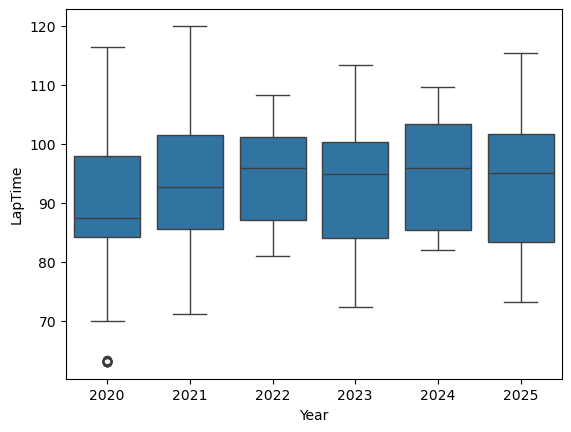

In [37]:
#check for outliers in laptime
sns.boxplot(x='Year', y='LapTime', data=laps_aggregated)
plt.show()

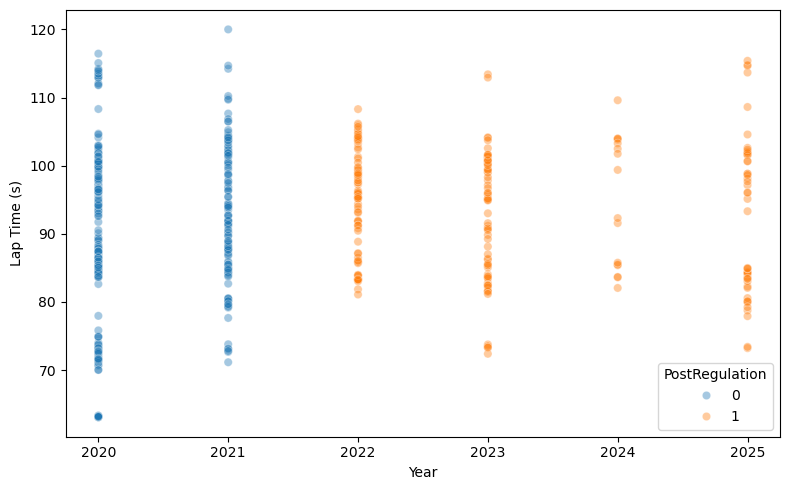

In [38]:
#plot distribution of laptime pre & post regulation
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=laps_aggregated,
    x='Year',
    y='LapTime',
    hue='PostRegulation',
    alpha=0.4
)

plt.xlabel("Year")
plt.ylabel("Lap Time (s)")
plt.tight_layout()
plt.show()

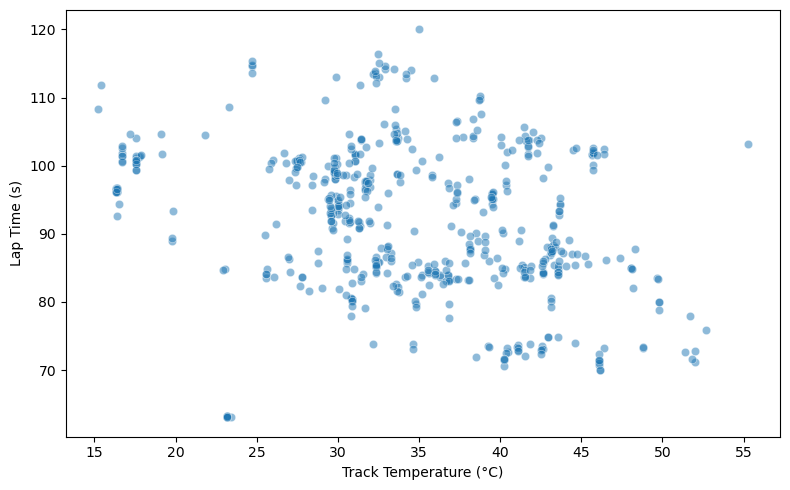

In [39]:
#compare laptime with tracktemp
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=laps_aggregated,
    x='TrackTemp',
    y='LapTime',
    alpha=0.5
)
plt.xlabel("Track Temperature (°C)")
plt.ylabel("Lap Time (s)")
plt.tight_layout()
plt.show()

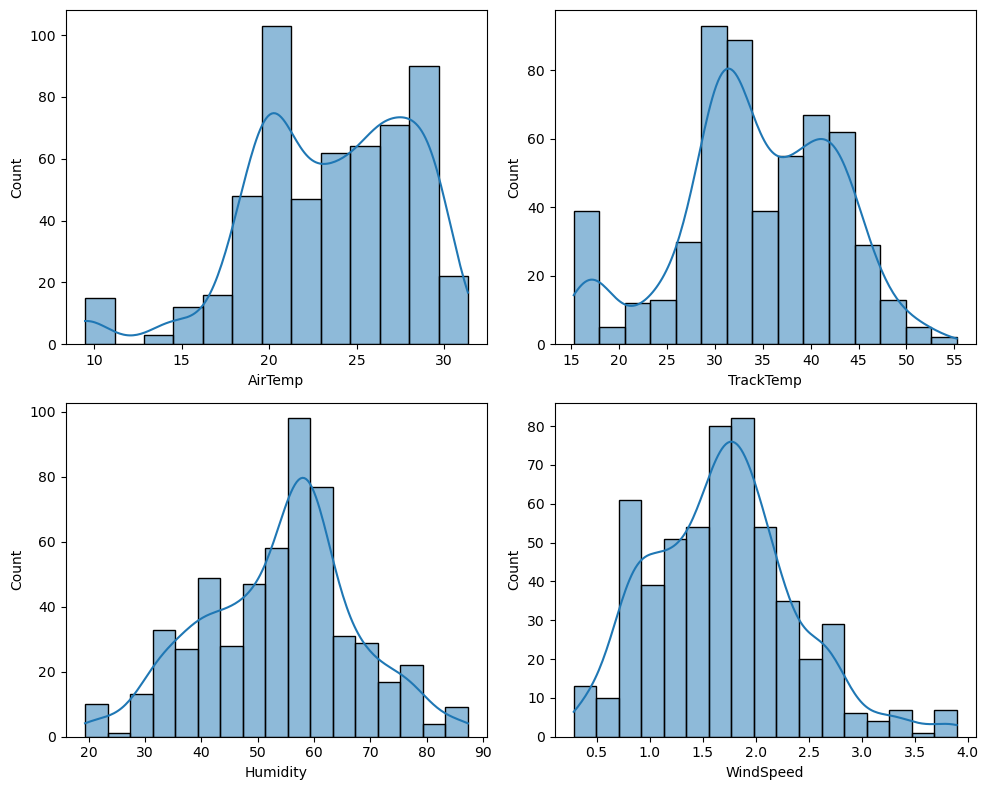

In [ ]:
#weather variable distributions
fig, axes = plt.subplots(2, 2, figsize=(10,8))
sns.histplot(laps_aggregated, x='AirTemp', ax=axes[0,0], kde=True)
sns.histplot(laps_aggregated, x='TrackTemp', ax=axes[0,1], kde=True)
sns.histplot(laps_aggregated, x='Humidity', ax=axes[1,0], kde=True)
sns.histplot(laps_aggregated, x='WindSpeed', ax=axes[1,1], kde=True)
plt.tight_layout()
plt.show()

**Mixed Effects Model (GLMM)**

/Users/seo/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seo/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/seo/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seo/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


Summary of Mixed Model
                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     LapTime   
No. Observations:      553         Method:                 REML      
No. Groups:            37          Scale:                  93.1447   
Min. group size:       1           Log-Likelihood:         -2029.3476
Max. group size:       26          Converged:              No        
Mean group size:       14.9                                          
---------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025  0.975]
---------------------------------------------------------------------
Intercept                100.475    4.917 20.436 0.000 90.839 110.112
Compound[T.INTERMEDIATE]  -0.053    2.062 -0.026 0.980 -4.093   3.988
Compound[T.MEDIUM]        -2.936    1.584 -1.853 0.064 -6.042   0.169
Compound[T.SOFT]          -5.887    1.698 -3.467 0.001 -9.215  -2.559
Compound[T.UN

/Users/seo/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seo/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/seo/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 15.540627
  warnings.warn(msg, ConvergenceWarning)
/Users/seo/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


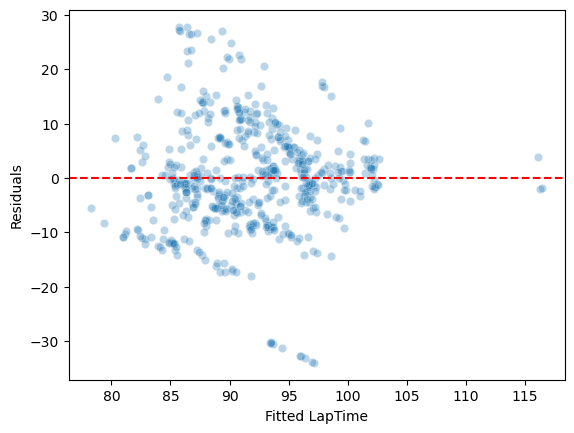

/var/folders/j5/byd_6b0s1xqcff_0967_q4c00000gn/T/ipykernel_58996/906585050.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(x='PostRegulation', y='LapTime', data=laps_aggregated, ci='sd')


Text(0.5, 1.0, 'Estimated Effect of Regulation on Lap Time')

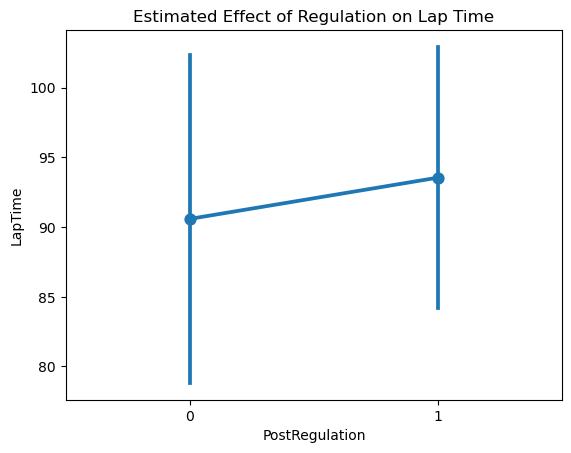

In [31]:
#ensure categorical columns
laps_aggregated['Driver'] = laps_aggregated['Driver'].astype('category')
laps_aggregated['Team'] = laps_aggregated['Team'].astype('category')
laps_aggregated['RaceName'] = laps_aggregated['RaceName'].astype('category')
laps_aggregated['Compound'] = laps_aggregated['Compound'].astype('category')

#fit linear mixed model
md = smf.mixedlm(
    "LapTime ~ PostRegulation + Compound + Stint + AirTemp + TrackTemp + Humidity",
    data=laps_aggregated,
    groups=laps_aggregated["Driver"],   # random intercept for Driver
    re_formula="~1"
)
mdf = md.fit()
print("Summary of Mixed Model")
print(mdf.summary())

#evaliuate RMSE
y_true = laps_aggregated['LapTime']
y_pred = mdf.fittedvalues
rmse = np.sqrt(np.mean((y_true - y_pred)**2))
print(f"RMSE: {rmse:.3f} sec")

#visualize residuals and plot
residuals = y_true - y_pred
sns.scatterplot(x=y_pred, y=residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted LapTime")
plt.ylabel("Residuals")
plt.show()

#
sns.pointplot(x='PostRegulation', y='LapTime', data=laps_aggregated, ci='sd')
plt.title("Estimated Effect of Regulation on Lap Time")

**Random Forrest Classification**

In [ ]:
#build numerical & target columns
target_column = 'PostRegulation'
categorical_features = ['Driver', 'Compound']
numerical_features = [
    'LapTime',
    'SpeedI1',
    'SpeedI2',
    'SpeedST',
    'SpeedFL',
    'AirTemp',
    'TrackTemp',
    'WindSpeed',
    'Humidity'
]

features_list = numerical_features + categorical_features
#check for missing data 
print(laps_aggregated[features_list + [target_column]].isnull().sum())
#define X/Y
X = laps_aggregated[features_list]
y = laps_aggregated[target_column]


#one-hot encoding
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)
print("Shape of X after encoding:", X_encoded.shape)
print("Columns in X_encoded:", X_encoded.columns.tolist())

#split data, 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

#iitialize classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
#fit model & run prediction
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

LapTime           0
SpeedI1           0
SpeedI2           0
SpeedST           0
SpeedFL           0
AirTemp           0
TrackTemp         0
WindSpeed         0
Humidity          0
Driver            0
Compound          0
PostRegulation    0
dtype: int64

Shape of X before encoding: (553, 11)
Shape of X after encoding: (553, 50)
Columns in X_encoded: ['LapTime', 'SpeedI1', 'SpeedI2', 'SpeedST', 'SpeedFL', 'AirTemp', 'TrackTemp', 'WindSpeed', 'Humidity', 'Driver_ALB', 'Driver_ALO', 'Driver_ANT', 'Driver_BEA', 'Driver_BOR', 'Driver_BOT', 'Driver_COL', 'Driver_DEV', 'Driver_DOO', 'Driver_GAS', 'Driver_GIO', 'Driver_GRO', 'Driver_HAD', 'Driver_HAM', 'Driver_HUL', 'Driver_KVY', 'Driver_LAT', 'Driver_LAW', 'Driver_LEC', 'Driver_MAG', 'Driver_MAZ', 'Driver_MSC', 'Driver_NOR', 'Driver_OCO', 'Driver_PER', 'Driver_PIA', 'Driver_RAI', 'Driver_RIC', 'Driver_RUS', 'Driver_SAI', 'Driver_SAR', 'Driver_STR', 'Driver_TSU', 'Driver_VER', 'Driver_VET', 'Driver_ZHO', 'Compound_INTERMEDIATE', 'Compound_MEDIU


Model Accuracy: 0.9640

Classification Report:
                     precision    recall  f1-score   support

 Pre-Regulation (0)       0.96      0.98      0.97        66
Post-Regulation (1)       0.98      0.93      0.95        45

           accuracy                           0.96       111
          macro avg       0.97      0.96      0.96       111
       weighted avg       0.96      0.96      0.96       111

Confusion Matrix:
[[65  1]
 [ 3 42]]

Confusion matrix plot saved as 'confusion_matrix.png'


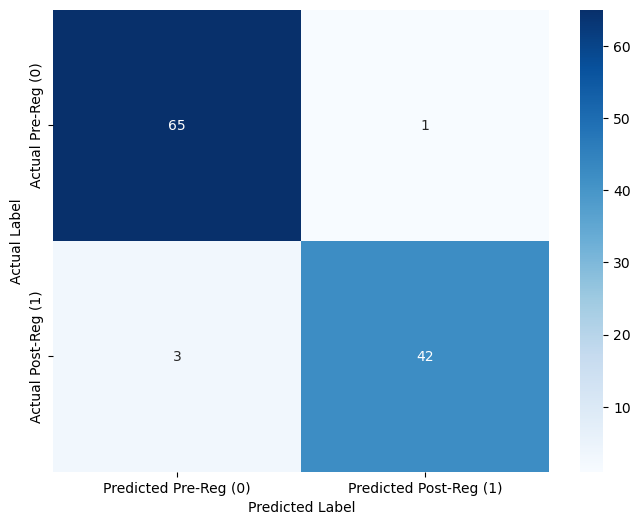

In [48]:
#model evaluation
#accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

#classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Pre-Regulation (0)', 'Post-Regulation (1)']))

#confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Pre-Reg (0)', 'Predicted Post-Reg (1)'],
            yticklabels=['Actual Pre-Reg (0)', 'Actual Post-Reg (1)'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
print("\nConfusion matrix plot saved as 'confusion_matrix.png'")

/var/folders/j5/byd_6b0s1xqcff_0967_q4c00000gn/T/ipykernel_58996/3455082381.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


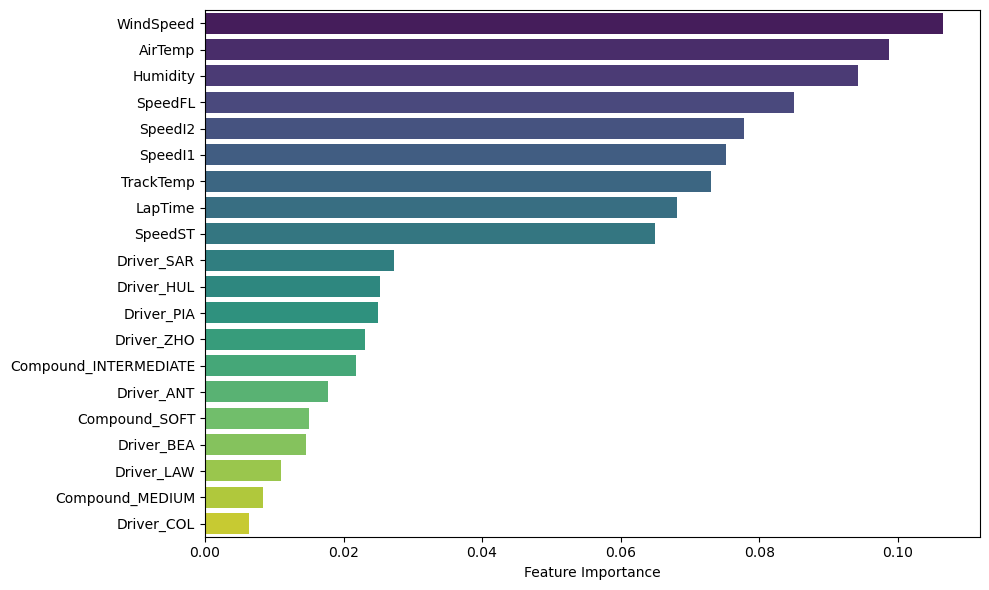

In [ ]:
importances = rf_classifier.feature_importances_
feature_names = X_encoded.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

#plot features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature',
            data=feature_importance_df.head(20),
            palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('')
plt.tight_layout()
plt.show()